In [13]:
from pysjef import Project, DirectoryNode, all_completed
from pysjef_molpro import no_errors
import numpy

In [14]:
root = DirectoryNode('dihedral_scan')

In [15]:
grid = numpy.linspace(0, 90, 20, endpoint=False)
for i, D in enumerate(grid):
    p = root.add_child(f'd{i}', suffix='molpro')
    p.write_input(
    f"""symmetry, xz, yz
    geometry={{
        H1
        C1 H1 rch
        C2 C1 rcc H1 A
        H2 C2 rch C1 A H1 D
        H3 C2 rch C1 A H2 180
        H4 C1 rch C2 A H1 180}}
    rch = 2.05; rcc = 2.65; A = 121.5; D ={D};
    basis = cc-pVTZ
    rhf
    {{casscf; closed, 3.1, 1.2, 1.3, 2.4; 
        occ, 3.1, 2.2, 2.3, 2.4; wf, sym=1}}
    {{optg; inactive, D}}
    {{casscf, so_sci;  closed, 3.1, 1.2, 1.3, 2.4;
        occ, 3.1, 2.2, 2.3, 2.4;
        wf, sym=1; wf, sym=4;}}
    {{mrci; core, 2; wf, sym=1;}}
    {{mrci; core, 2; wf, sym=4;}}""")

In [16]:
from multiprocessing.dummy import Pool
from operator import methodcaller
with Pool(processes=8) as pool:
    pool.map(methodcaller('run', backend='local', wait=True),
             root.children, 1)
print('all completed', all_completed(root.children))
print('without errors', no_errors(root.children))

all completed True
without errors True


<IPython.core.display.Javascript object>


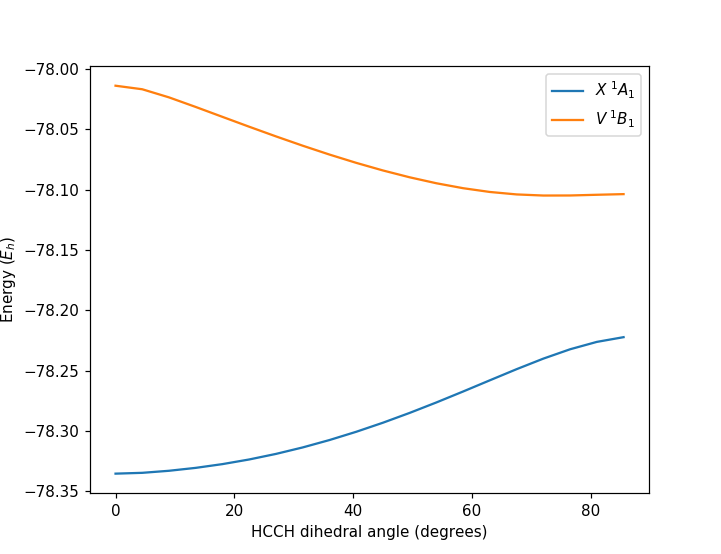

In [22]:
import matplotlib.pyplot as plt
%matplotlib notebook
energies = root.select('//jobstep[command=MRCI]/property[name=Energy].value')
e1, e2 = energies[::2], energies[1::2]
cc = root.select('//variable[name=rcc]/value..')
plt.plot(grid, e1, grid, e2)
plt.legend([r'$X\;{}^1A_1$',r'$V\;{}^1B_1$'])
plt.xlabel('HCCH dihedral angle (degrees)')
plt.ylabel(r'Energy $(E_h)$')
plt.show()

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 900

<IPython.core.display.Javascript object>


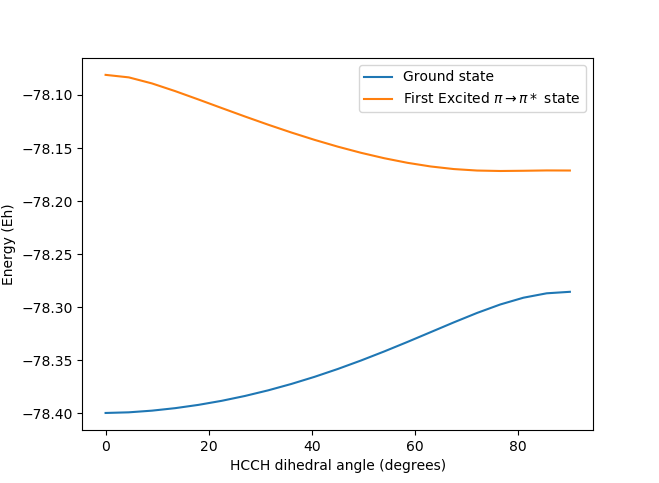

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook
energies = root.select('//property[name=Energy, method=MRCI].value')
e1, e2 = energies[::2], energies[1::2]
cc = root.select('//variable[name=rcc]/value..')
plt.plot(grid, e1, grid, e2)
plt.legend(['Ground state',r'First Excited $\pi \rightarrow \pi*$ state'])
plt.xlabel('HCCH dihedral angle (degrees)')
plt.ylabel('Energy (Eh)')
plt.show()

<IPython.core.display.Javascript object>


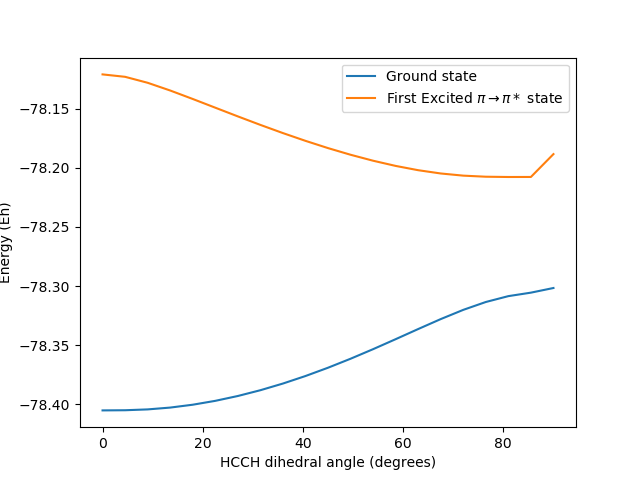

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook
energies = root.select('//property[name=Energy, method=RSPT2].value')
e1, e2 = energies[::2], energies[1::2]
cc = root.select('//variable[name=rcc]/value..')
plt.plot(grid, e1, grid, e2)
plt.legend(['Ground state',r'First Excited $\pi \rightarrow \pi*$ state'])
plt.xlabel('HCCH dihedral angle (degrees)')
plt.ylabel('Energy (Eh)')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
energies = []
for p in root.children:
    n = p.select('//jobstep[command=CASSCF]')[-1]
    energies.append(n.select('property[name=energy].value'))
e1, e2, e3 = zip(*energies)
cc = root.select('//variable[name=rcc]/value..')
plt.plot(grid, e1, grid, e2,  grid, e3)
plt.legend(['Ground state','Excited state'])
plt.xlabel('HCCH dihedral angle (degrees)')
plt.ylabel('Energy (Eh)')
plt.show()